# 1. Data

In [1]:
# loading necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('thl_recoded.csv')
data.head()

,target,weight,sensecoh,ageatfdr,gn_2.0,household_1.0,psydsord_1.0,chrodse_1.0,prhealth_1.0,psydist_1.0,...,ecactiv_2.0,ecactiv_3.0,ecactiv_4.0,BDI3_0.0,BDI3_1.0,BDI3_2.0,phyact_1.0,phyact_2.0,phyact_3.0,phyact_4.0
0,0.0,1.086293,65.0,17.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,1.086293,73.0,19.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,1.086293,59.0,18.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.086293,64.0,17.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.945237,58.0,15.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [3]:
 # Kannabis use
data['target'].value_counts(normalize= True)

0.0    0.513158
1.0    0.486842
Name: target, dtype: float64

## 1.1. Combination of Over- and Under-sampling/ Hybrid Methods

In the previous stage, we learned that the best sampling strategy for this data set is hybrit method. For that reason, we will continue with this method for the rest of the re-sampling processes.  

In [4]:
# resample by adding samples to minority class using SMOTE
from collections import Counter
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

from sklearn.model_selection import train_test_split
X, y = data.iloc[:, 1:].values, data.iloc[:, 0].values



#split data train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.25,
                                                    random_state = 10)



print(f"Class counts after resampling {Counter(y)}")

Class counts after resampling Counter({0.0: 195, 1.0: 185})


In [5]:
# Scaling
from sklearn.preprocessing import RobustScaler

robust = RobustScaler()
X_train_std = robust.fit_transform(X_train)
X_test_std = robust.transform(X_test)

# 2. Selecting best classifier with RFEVC
This is a fast method to check which classifier works better. RFECV determines number of features automatically, so in this stage, we are not interested in how many features are in the model, instead, which model produce higer accuracy rate. Since it is an unbalanced data, I will use f1 score for model performance. 

Xboost changed its algorithms, I do not have time to fix it here, so I just muted it. 

In [6]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.pipeline import Pipeline


# create pipeline of differennt base algorithms to be used in RFECV 
# (no. of features will be auto-selected based on cv in RFECV)
models = {}
# logistic regression
rfecv = RFECV(estimator = LogisticRegression(solver='lbfgs', max_iter=1000), cv = 5, scoring = 'f1_macro')
model = DecisionTreeClassifier()
models['LR'] = Pipeline(steps = [('features', rfecv), ('model', model)])
# decision tree
rfecv = RFECV(estimator = DecisionTreeClassifier(), cv = 5, scoring = 'f1_macro')
model = DecisionTreeClassifier()
models['DT'] = Pipeline(steps = [('features', rfecv), ('model', model)])
# random forest
rfecv = RFECV(estimator = RandomForestClassifier(), cv = 5, scoring = 'f1_macro')
model = DecisionTreeClassifier()
models['RF'] = Pipeline(steps = [('features', rfecv), ('model', model)])

# XGBoost Classifier
#rfecv = RFECV(estimator=XGBClassifier(), cv = 2, scoring = 'accuracy')
#model = DecisionTreeClassifier()
#models['XGB'] = Pipeline(steps = [('features', rfecv), ('model', model)])


# Gradient Boosting Classifier
rfecv = RFECV(estimator=GradientBoostingClassifier(), cv = 5, scoring = 'f1_macro')
model = DecisionTreeClassifier()
models['GBC'] = Pipeline(steps = [('features', rfecv), ('model', model)])

# Perceptron
rfecv = RFECV(estimator=Perceptron(), cv = 5, scoring = 'f1_macro')
model = DecisionTreeClassifier()
models['PER'] = Pipeline(steps = [('features', rfecv), ('model', model)])


# SCV - default rbf
rfecv = RFECV(estimator= SVC(kernel='linear'), cv = 5, scoring = 'f1_macro')
model = DecisionTreeClassifier()
models['SVC'] = Pipeline(steps = [('features', rfecv), ('model', model)])


# evaluate all the models
results = []
names = []
for name, model in models.items():
    cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 5, random_state = 1)
    scores = cross_val_score(model, X_train_std, y_train, scoring = 'accuracy', cv = cv, n_jobs = -1)
    results.append(scores)
    names.append(name)
    print('>%s: %.3f' % (name, np.mean(scores)))

>LR: 0.545
>DT: 0.525
>RF: 0.519
>GBC: 0.528
>PER: 0.528
>SVC: 0.517


**Summary:** Results show that GBC, RF and LR models have a higher f1 score on feature elimination. However, we do not know yet how many features the models used to produce these resutls. 

## 2.1. RFE Classifier with a given number of features

In this stage, we can give a predetermined feature size and look for model performances. Put differently, let's say if we want to use less than 20 features, which model have higher f1 scores. 

In [7]:

# explore the algorithm wrapped by RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

In [8]:
# set the number of fetures
number_of_futures = 10

# get a list of models to evaluate
def get_models():
    models = dict()
    # lr
    rfe = RFE(estimator=LogisticRegression(solver='lbfgs', max_iter=1000), n_features_to_select=number_of_futures)
    model = DecisionTreeClassifier()
    models['lr'] = Pipeline(steps=[('s',rfe),('m',model)])
    # perceptron
    rfe = RFE(estimator=Perceptron(), n_features_to_select=number_of_futures)
    model = DecisionTreeClassifier()
    models['per'] = Pipeline(steps=[('s',rfe),('m',model)])
    # cart
    rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=number_of_futures)
    model = DecisionTreeClassifier()
    models['cart'] = Pipeline(steps=[('s',rfe),('m',model)])
    # rf
    rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=number_of_futures)
    model = DecisionTreeClassifier()
    models['rf'] = Pipeline(steps=[('s',rfe),('m',model)])
    # gbm
    rfe = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=number_of_futures)
    model = DecisionTreeClassifier()
    models['gbm'] = Pipeline(steps=[('s',rfe),('m',model)])
    # SCV - default rbf
    rfe = RFE(estimator= SVC(kernel='linear'), n_features_to_select=number_of_futures)
    model = DecisionTreeClassifier()
    models['SVC'] = Pipeline(steps = [('s',rfe),('m',model)])

    
    

    return models

In [9]:
# evaluate a give model using cross-validation
def evaluate_model(model, X_train_std, y_train):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
    scores = cross_val_score(model, X_train_std, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
    return scores

In [10]:
# get the models to evaluate
models = get_models()

>lr 0.528 (0.063)
>per 0.513 (0.070)
>cart 0.519 (0.069)
>rf 0.521 (0.048)
>gbm 0.510 (0.062)
>SVC 0.510 (0.070)


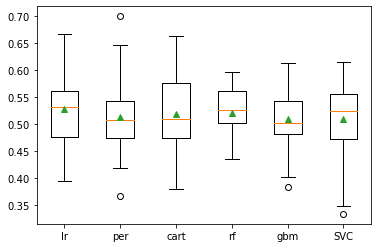

In [11]:
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train_std, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

**Summary:** The results show that GBM performs well with 10 features. 

# Select the minumum features

In this stage, we will look at more closely to the models, their performance and features they give importance. Here, we basically determine a model that works well for our expectations. 


In [12]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
import numpy as np


In [13]:
def feature_selection( X_train, X_test, y_train, y_test, model, estimator, n_split, n_repeat ):
    from sklearn.feature_selection import RFECV
    
    model_estimator = estimator
    
    #  RFECV model 
    rfecv = RFECV(estimator= model_estimator)
    model = model
    
    pipeline = Pipeline([('Feature Selection', rfecv), ('Model', model)])
    cv = RepeatedStratifiedKFold(n_splits=n_split, n_repeats=n_repeat, random_state=92116)
    n_scores = cross_val_score(pipeline, X_train, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
    np.mean(n_scores)
    

    # model fit 
    pipeline.fit(X_train, y_train)
    print('Optimal number of features : %d' % rfecv.n_features_)


    # Confusion matrix 
    y_pred = pipeline.predict(X_test)
    from sklearn import metrics
    from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import accuracy_score

    print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),4))
    print('Precision:', np.round(metrics.precision_score(y_test, y_pred,average='weighted'),4))
    print('Recall:', np.round(metrics.recall_score(y_test, y_pred,
                                               average='weighted'),4))
    print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred,
                                               average='weighted'),4))
    print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, y_pred),4))
    print('Matthews Corrcoef:', np.round(metrics.matthews_corrcoef(y_test, y_pred),4)) 

    from sklearn.metrics import roc_auc_score
    print("roc_auc_score:", roc_auc_score(y_test, y_pred, average=None))

    print('\t\tClassification Report:\n', metrics.classification_report(y_pred,y_test))


    from sklearn.metrics import confusion_matrix
    print("Confusion Matrix:\n",confusion_matrix(y_test, y_pred))


    #Plot Confusion Matrix
    from sklearn.metrics import confusion_matrix
    from io import BytesIO #neded for plot
    import seaborn as sns; sns.set()
    import matplotlib.pyplot as plt

    mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)


    plt.xlabel('true label')
    plt.ylabel('predicted label');
    
    
    # Feature plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,6))
    plt.xlabel('Number of features selected')
    plt.ylabel('Cross validation score (nb of correct classifications)')
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    
    # List of features
    rfecv.support_rfecv_df = pd.DataFrame(rfecv.ranking_,index=data.columns[1:],columns=['Rank']).sort_values(by='Rank',ascending=True)

    dt_columns = rfecv.support_rfecv_df [rfecv.support_rfecv_df ['Rank']==1].reset_index()
    dt_columns = list(np.array(dt_columns['index']))
    

    

    return rfecv.support_rfecv_df
    
    
    


##  RFECV Gradient Boosting

Optimal number of features : 23
Accuracy: 0.5579
Precision: 0.5618
Recall: 0.5579
F1 Score: 0.5576
Cohen Kappa Score: 0.1192
Matthews Corrcoef: 0.1202
roc_auc_score: 0.5599999999999999
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.60      0.53      0.56        51
         1.0       0.52      0.59      0.55        44

    accuracy                           0.56        95
   macro avg       0.56      0.56      0.56        95
weighted avg       0.56      0.56      0.56        95

Confusion Matrix:
 [[27 18]
 [24 26]]


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


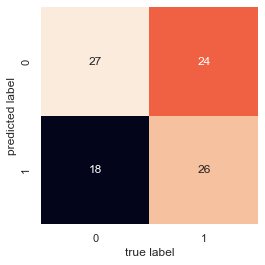

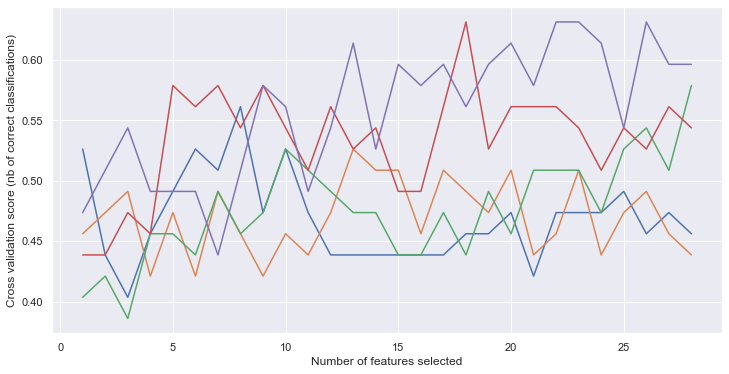

,Rank
weight,1
phyact_2.0,1
phyact_1.0,1
BDI3_1.0,1
ecactiv_3.0,1
ecactiv_1.0,1
edu_3.0,1
edu_2.0,1
edu_1.0,1
phyact_3.0,1


In [14]:
from sklearn.ensemble import GradientBoostingClassifier
estimator = GradientBoostingClassifier()
model = GradientBoostingClassifier()
# crosvalidation 
n_split = 5
n_repeat = 5


feature_selection(X_train_std, X_test_std, y_train, y_test, model, estimator,  n_split, n_repeat)

## RFECV SCV

Optimal number of features : 5
Accuracy: 0.5474
Precision: 0.5479
Recall: 0.5474
F1 Score: 0.5476
Cohen Kappa Score: 0.0932
Matthews Corrcoef: 0.0933
roc_auc_score: 0.5466666666666666
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.53      0.52      0.53        46
         1.0       0.56      0.57      0.57        49

    accuracy                           0.55        95
   macro avg       0.55      0.55      0.55        95
weighted avg       0.55      0.55      0.55        95

Confusion Matrix:
 [[24 21]
 [22 28]]


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


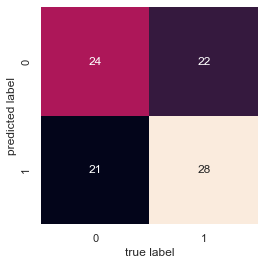

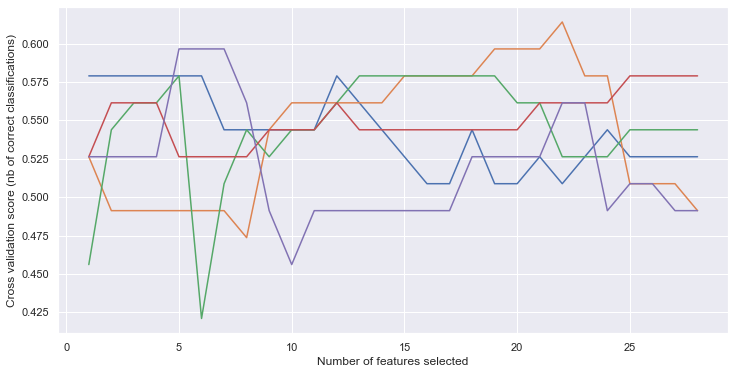

,Rank
phyact_4.0,1
phyact_2.0,1
smoking_1.0,1
ecactiv_2.0,1
ecactiv_1.0,1
psydist_1.0,2
BDI3_0.0,3
chrodse_1.0,4
ecactiv_4.0,5
edu_1.0,6


In [15]:
from sklearn.svm import SVC

estimator =  SVC(kernel="linear", C=50)
model = SVC(kernel="linear", C= 50)

# crosvalidation 
n_split = 5
n_repeat = 5


feature_selection(X_train_std, X_test_std, y_train, y_test, model, estimator,  n_split, n_repeat)

## RFECV Randon Forest 

Optimal number of features : 25
Accuracy: 0.5158
Precision: 0.5206
Recall: 0.5158
F1 Score: 0.5145
Cohen Kappa Score: 0.0374
Matthews Corrcoef: 0.038
roc_auc_score: 0.5188888888888888
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.58      0.49      0.53        53
         1.0       0.46      0.55      0.50        42

    accuracy                           0.52        95
   macro avg       0.52      0.52      0.52        95
weighted avg       0.53      0.52      0.52        95

Confusion Matrix:
 [[26 19]
 [27 23]]


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


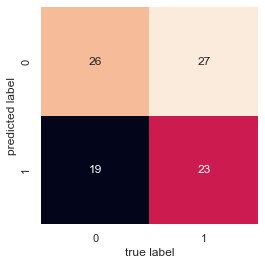

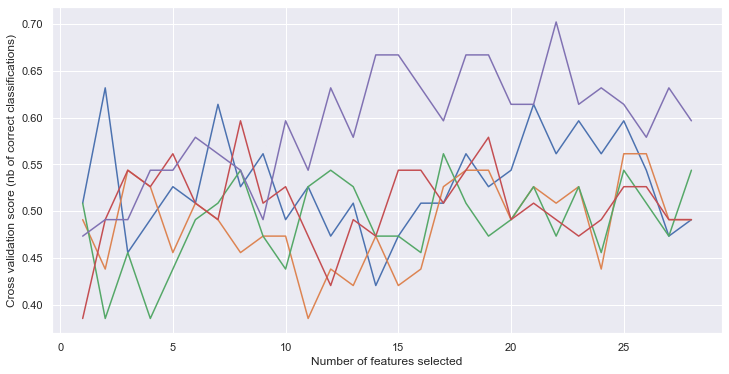

,Rank
weight,1
phyact_2.0,1
phyact_1.0,1
BDI3_1.0,1
BDI3_0.0,1
ecactiv_3.0,1
ecactiv_2.0,1
ecactiv_1.0,1
edu_3.0,1
edu_2.0,1


In [16]:
from sklearn.ensemble import RandomForestClassifier

estimator= RandomForestClassifier()
model = RandomForestClassifier(n_estimators=100, random_state=92116)

# crosvalidation 
n_split = 5
n_repeat = 5


feature_selection(X_train_std, X_test_std, y_train, y_test, model, estimator,  n_split, n_repeat)

## RFECV Decision Tree 

Optimal number of features : 20
Accuracy: 0.6632
Precision: 0.668
Recall: 0.6632
F1 Score: 0.6629
Cohen Kappa Score: 0.3289
Matthews Corrcoef: 0.3316
roc_auc_score: 0.6655555555555556
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.71      0.63      0.67        51
         1.0       0.62      0.70      0.66        44

    accuracy                           0.66        95
   macro avg       0.67      0.67      0.66        95
weighted avg       0.67      0.66      0.66        95

Confusion Matrix:
 [[32 13]
 [19 31]]


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


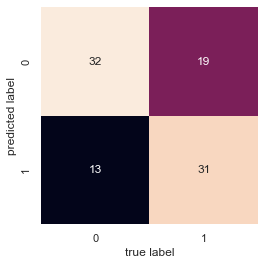

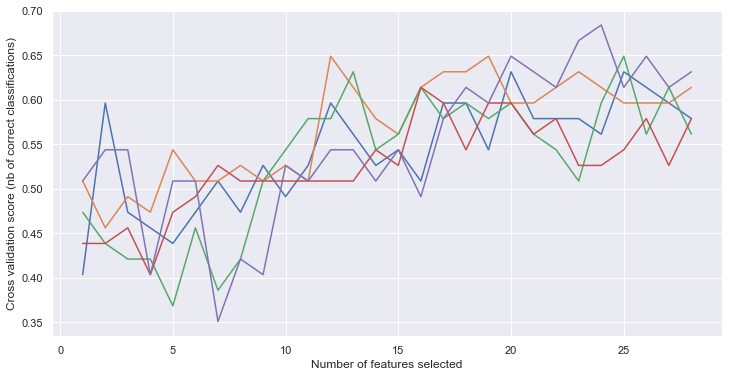

,Rank
weight,1
BDI3_2.0,1
BDI3_1.0,1
ecactiv_4.0,1
ecactiv_1.0,1
edu_3.0,1
edu_2.0,1
edu_1.0,1
phyact_1.0,1
age_1.0,1


In [17]:
from sklearn.tree import DecisionTreeClassifier

estimator= DecisionTreeClassifier()
model = DecisionTreeClassifier()

# crosvalidation 
n_split = 5
n_repeat = 5


feature_selection(X_train_std, X_test_std, y_train, y_test, model, estimator,  n_split, n_repeat)

## RFECV LR 

Optimal number of features : 1
Accuracy: 0.5789
Precision: 0.6622
Recall: 0.5789
F1 Score: 0.4943
Cohen Kappa Score: 0.1204
Matthews Corrcoef: 0.197
roc_auc_score: 0.5577777777777777
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.16      0.78      0.26         9
         1.0       0.96      0.56      0.71        86

    accuracy                           0.58        95
   macro avg       0.56      0.67      0.48        95
weighted avg       0.88      0.58      0.66        95

Confusion Matrix:
 [[ 7 38]
 [ 2 48]]


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


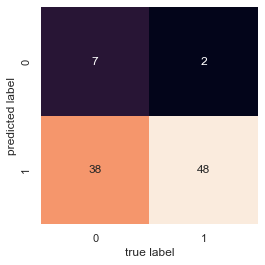

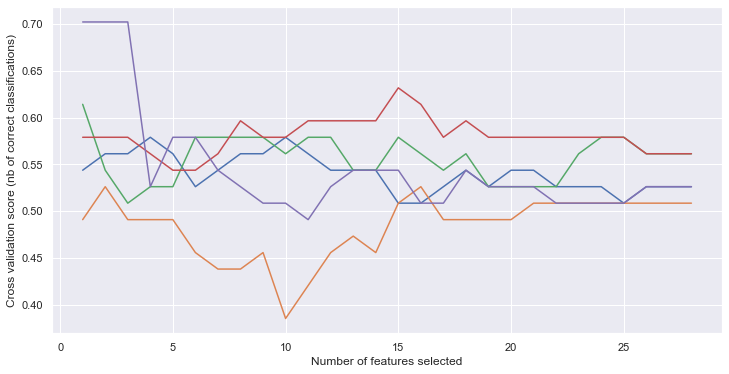

,Rank
age_3.0,1
ecactiv_1.0,2
smoking_1.0,3
ecactiv_4.0,4
ecactiv_2.0,5
BDI3_1.0,6
phyact_1.0,7
psydist_1.0,8
edu_2.0,9
edu_3.0,10


In [18]:
from sklearn.linear_model import LogisticRegression

estimator= LogisticRegression(solver='lbfgs', max_iter=1000)
model = LogisticRegression(solver='lbfgs', max_iter=1000)

# crosvalidation 
n_split = 5
n_repeat = 5


feature_selection(X_train_std, X_test_std, y_train, y_test, model, estimator,  n_split, n_repeat)

# Final Process

Our results shows that RF produces the better results with less features. To analyze it more in details and extract the features, we will conduct RFE analysis. 

## 15 Features

In [56]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
import numpy as np



In [64]:
from sklearn.ensemble import GradientBoostingClassifier
rfe = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=15)
model = GradientBoostingClassifier()

from sklearn.ensemble import RandomForestClassifier
#rfe= RFE(RandomForestClassifier(), n_features_to_select=15)
#model = RandomForestClassifier(n_estimators=100, random_state=92116)


from sklearn.tree import DecisionTreeClassifier
#rfe= RFE(DecisionTreeClassifier(), n_features_to_select=15)
#model = DecisionTreeClassifier()




pipeline = Pipeline([('Feature Selection', rfe), ('Model', model)])
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=92116)
n_scores = cross_val_score(pipeline, X_train_std, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
np.mean(n_scores)


0.5232828291460527

In [65]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('Feature Selection',
                 RFE(estimator=GradientBoostingClassifier(),
                     n_features_to_select=15)),
                ('Model', GradientBoostingClassifier())])

Accuracy: 0.5895
Precision: 0.5912
Recall: 0.5895
F1 Score: 0.5897
Cohen Kappa Score: 0.1794
Matthews Corrcoef: 0.1798
roc_auc_score: 0.59
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.60      0.56      0.58        48
         1.0       0.58      0.62      0.60        47

    accuracy                           0.59        95
   macro avg       0.59      0.59      0.59        95
weighted avg       0.59      0.59      0.59        95

Confusion Matrix:
 [[27 18]
 [21 29]]


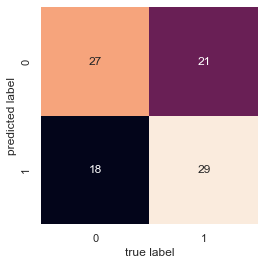

In [66]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_pred = pipeline.predict(X_test)

print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),4))
print('Precision:', np.round(metrics.precision_score(y_test, y_pred,average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_test, y_pred,
                                               average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred,
                                               average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, y_pred),4))
print('Matthews Corrcoef:', np.round(metrics.matthews_corrcoef(y_test, y_pred),4)) 

from sklearn.metrics import roc_auc_score
print("roc_auc_score:", roc_auc_score(y_test, y_pred, average=None))

print('\t\tClassification Report:\n', metrics.classification_report(y_pred,y_test))


from sklearn.metrics import confusion_matrix
print("Confusion Matrix:\n",confusion_matrix(y_test, y_pred))


#Plot Confusion Matrix
from sklearn.metrics import confusion_matrix
from io import BytesIO #neded for plot
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)


plt.xlabel('true label')
plt.ylabel('predicted label');

plt.savefig("Confusion.jpg")
# Save SVG in a fake file object.
f = BytesIO()
plt.savefig(f, format="svg")

In [67]:
rfe.support_

array([ True,  True,  True,  True,  True,  True, False, False,  True,
       False,  True, False,  True, False, False,  True, False,  True,
       False,  True, False, False,  True, False,  True,  True, False,
       False])

In [68]:
pd.DataFrame(rfe.support_,index=data.columns[1:],columns=['Rank'])

,Rank
weight,True
sensecoh,True
ageatfdr,True
gn_2.0,True
household_1.0,True
psydsord_1.0,True
chrodse_1.0,False
prhealth_1.0,False
psydist_1.0,True
familyhist_1.0,False


In [69]:
rf_df = pd.DataFrame(rfe.ranking_,index=data.columns[1:],columns=['Rank']).sort_values(by='Rank',ascending=True)
rf_df

,Rank
weight,1
ecactiv_1.0,1
ecactiv_3.0,1
age_2.0,1
BDI3_1.0,1
smoking_1.0,1
edu_2.0,1
psydist_1.0,1
phyact_2.0,1
psydsord_1.0,1


In [70]:
# list of features for further use

dt_cloumns = rf_df[rf_df['Rank']==1].reset_index()
dt_cloumns= dt_cloumns['index'].to_list()
dt_cloumns

['weight',
 'ecactiv_1.0',
 'ecactiv_3.0',
 'age_2.0',
 'BDI3_1.0',
 'smoking_1.0',
 'edu_2.0',
 'psydist_1.0',
 'phyact_2.0',
 'psydsord_1.0',
 'household_1.0',
 'gn_2.0',
 'ageatfdr',
 'sensecoh',
 'phyact_1.0']

## 10 Features

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
import numpy as np



In [49]:
from sklearn.ensemble import GradientBoostingClassifier
#rfe = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=15)
#model = GradientBoostingClassifier()

from sklearn.ensemble import RandomForestClassifier
#rfe= RFE(RandomForestClassifier(), n_features_to_select=10)
#model = RandomForestClassifier(n_estimators=100, random_state=92116)

from sklearn.tree import DecisionTreeClassifier
rfe= RFE(DecisionTreeClassifier(), n_features_to_select=10)
model = DecisionTreeClassifier()



pipeline = Pipeline([('Feature Selection', rfe), ('Model', model)])
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=92116)
n_scores = cross_val_score(pipeline, X_train_std, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
np.mean(n_scores)


0.5024143995371404

In [50]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('Feature Selection',
                 RFE(estimator=DecisionTreeClassifier(),
                     n_features_to_select=10)),
                ('Model', DecisionTreeClassifier())])

Accuracy: 0.6
Precision: 0.6065
Recall: 0.6
F1 Score: 0.5989
Cohen Kappa Score: 0.2048
Matthews Corrcoef: 0.2078
roc_auc_score: 0.6033333333333334
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.67      0.57      0.61        53
         1.0       0.54      0.64      0.59        42

    accuracy                           0.60        95
   macro avg       0.60      0.60      0.60        95
weighted avg       0.61      0.60      0.60        95

Confusion Matrix:
 [[30 15]
 [23 27]]


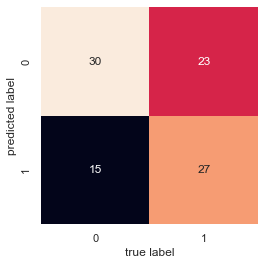

In [51]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_pred = pipeline.predict(X_test)

print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),4))
print('Precision:', np.round(metrics.precision_score(y_test, y_pred,average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_test, y_pred,
                                               average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred,
                                               average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, y_pred),4))
print('Matthews Corrcoef:', np.round(metrics.matthews_corrcoef(y_test, y_pred),4)) 

from sklearn.metrics import roc_auc_score
print("roc_auc_score:", roc_auc_score(y_test, y_pred, average=None))

print('\t\tClassification Report:\n', metrics.classification_report(y_pred,y_test))


from sklearn.metrics import confusion_matrix
print("Confusion Matrix:\n",confusion_matrix(y_test, y_pred))


#Plot Confusion Matrix
from sklearn.metrics import confusion_matrix
from io import BytesIO #neded for plot
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)


plt.xlabel('true label')
plt.ylabel('predicted label');

plt.savefig("Confusion.jpg")
# Save SVG in a fake file object.
f = BytesIO()
plt.savefig(f, format="svg")

In [52]:
rfe.support_

array([ True,  True,  True,  True,  True, False, False,  True, False,
       False, False,  True, False, False, False,  True, False,  True,
       False, False, False, False,  True, False, False, False, False,
       False])

In [53]:
pd.DataFrame(rfe.support_,index=data.columns[1:],columns=['Rank'])

,Rank
weight,True
sensecoh,True
ageatfdr,True
gn_2.0,True
household_1.0,True
psydsord_1.0,False
chrodse_1.0,False
prhealth_1.0,True
psydist_1.0,False
familyhist_1.0,False


In [54]:
rf_df = pd.DataFrame(rfe.ranking_,index=data.columns[1:],columns=['Rank']).sort_values(by='Rank',ascending=True)
rf_df

,Rank
weight,1
sensecoh,1
ageatfdr,1
gn_2.0,1
household_1.0,1
BDI3_1.0,1
prhealth_1.0,1
ecactiv_1.0,1
edu_2.0,1
age_1.0,1


In [55]:
# list of features for further use

dt_cloumns = rf_df[rf_df['Rank']==1].reset_index()
dt_cloumns= dt_cloumns['index'].to_list()
dt_cloumns

['weight',
 'sensecoh',
 'ageatfdr',
 'gn_2.0',
 'household_1.0',
 'BDI3_1.0',
 'prhealth_1.0',
 'ecactiv_1.0',
 'edu_2.0',
 'age_1.0']

# 5. Summary 

These 15 features are enough to predict cannabis use with a %96 accuracy rate. In the next stage, we will look a bit more closer to the feature and then build a prediction model. If you would like to see how the same process could be done with SHAP method, you can find that file in the main folder. 